In [0]:
#### 
#### Dl assignment --> 2 
##$ Pramod Yadav

In [0]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader, TensorDataset, SequentialSampler, RandomSampler
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split


In [0]:
no_of_epochs = 10
btch_size = 32
lrn_rate = 0.0002
adam_d_beta_1 = 0.5
adam_d_beta_2 = 0.999
no_cpu_thr = 8
latent_dims = 100
img_dims = 128
img_chnls_dims = (3, 128, 128)
no_img_chnls = 3
int_btw_img_smpls = 50

In [0]:

os.makedirs("images_3", exist_ok=True)

In [0]:
cuda = True if torch.cuda.is_available() else False

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(3*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 100),
            #nn.Tanh(),
            #nn.Linear(12, 3),   # compress to 3 features which can be visualized in plt
        )
        self.decoder = nn.Sequential(
            #nn.Linear(3, 12),
            #nn.Tanh(),
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28*3),
            #nn.Sigmoid(),       # compress to a range (0, 1)
        )
    """
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dims, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_chnls_dims))),
            nn.Tanh()
        )
        self.avgpool =  nn.AdaptiveAvgPool2d(1)
    """

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(-1, 3, 28, 28)
        return encoded, decoded
        """
        img = self.model(z)
        img = img.view(img.size(0), *img_chnls_dims)
        return img
        """


In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(3*28*28, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)

        return validity

In [0]:
# Loss function
adversarial_loss = torch.nn.BCELoss()
loss_func = nn.MSELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

In [0]:
# Optimizers
optimizer_Gen = torch.optim.Adam(generator.parameters(), lr=lrn_rate, betas=(adam_d_beta_1, adam_d_beta_2))
optimizer_Disc = torch.optim.Adam(discriminator.parameters(), lr=lrn_rate, betas=(adam_d_beta_1, adam_d_beta_2))


In [0]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

img_dir = '/home/pramod/planet/DL/Assign_2/faces94'

imgS_1 = glob(f"{img_dir}/**/**/*.jpg")

In [0]:
imgS_1[:10]

3059


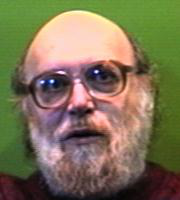

In [0]:
print(len(imgS_1))
Image.open(imgS_1[1])

In [0]:
labels = {"female" : 0, "male" : 1, "malestaff" : 2}

In [0]:
transform_loader = transforms.Compose([transforms.RandomResizedCrop((28,28)),transforms.RandomHorizontalFlip(),transforms.RandomRotation(10),transforms.ToTensor(),transforms.Normalize([0.5],[0.5])])

imgS_2 = torch.stack([transform_loader(Image.open(i)) for i in imgS_1])

labels_2 = torch.tensor([labels[i.split('/')[-3]] for i in imgS_1])

trainData, testData = train_test_split(range(len(imgS_2)), test_size = 0.2, random_state = 102)

trainData_imgS = imgS_2[trainData]
trainData_labels = labels_2[trainData]

testData_imgS = imgS_2[testData]
testData_labels = labels_2[testData]

trainDataTensor = TensorDataset(trainData_imgS,trainData_labels)
testDataTensor = TensorDataset(testData_imgS,testData_labels)

trainDataSmpls = RandomSampler(trainDataTensor)
testDataSmpls = SequentialSampler(testDataTensor)

trainDataLoader = DataLoader(trainDataTensor, sampler=trainDataSmpls, batch_size=btch_size)
testDataLoader = DataLoader(testDataTensor, sampler=testDataSmpls, batch_size=btch_size)
print("done")

done


In [0]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
unNorm = UnNormalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])

for epoch in range(no_of_epochs):
    gen_imgs_2 = None
    for i, (imgs, _) in enumerate(trainDataLoader):

        #Ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))
        
        b_x = imgs.view(-1, 3, 28, 28)   # batch x, shape (batch, 28*28)
        b_y = imgs.view(-1, 3, 28, 28)   # batch y, shape (batch, 28*28)
        #print(x.shape)
        
        gen_imgs_1,gen_imgs_2 = generator(b_x)
        
       # encoded, decoded = autoencoder(b_x)
        
        gen_loss = loss_func(gen_imgs_2, b_y)      # mean square error
        optimizer_Gen.zero_grad()               # clear gradients for this training step
        gen_loss.backward()                     # backpropagation, compute gradients
        optimizer_Gen.step()
        #print(imgs.size(0))
        #print(discriminator(real_imgs).size())
        #print(valid.size())
        """
        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dims))))

        # Generate a batch of images
        gen_imgs_1,gen_imgs_2 = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs_2), valid)

        g_loss.backward()
        optimizer_G.step()
        """

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_Disc.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_img_loss = loss_func(discriminator(real_imgs), valid)
        fake_img_loss = loss_func(discriminator(gen_imgs_2.detach()), fake)
        disc_loss = (real_img_loss + fake_img_loss) / 2

        disc_loss.backward()
        optimizer_Disc.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [discriminator_loss: %f] [generator_loss: %f]"
            % (epoch+1, no_of_epochs, i+1, len(trainDataLoader), disc_loss.item(), gen_loss.item())
        )

        batches_done = epoch * len(trainDataLoader) + i
        if batches_done % int_btw_img_smpls == 0:
            save_image(gen_imgs_2.data[:25], "images_3/e"+str(no_of_epochs)+"_"+str(epoch+1)+"_%d.png" % batches_done, nrow=5, normalize=True)


[Epoch 1/10] [Batch 1/77] [discriminator_loss: 0.253221] [generator_loss: 0.313441]
[Epoch 1/10] [Batch 2/77] [discriminator_loss: 0.226045] [generator_loss: 0.338651]
[Epoch 1/10] [Batch 3/77] [discriminator_loss: 0.198943] [generator_loss: 0.343001]
[Epoch 1/10] [Batch 4/77] [discriminator_loss: 0.198020] [generator_loss: 0.322917]
[Epoch 1/10] [Batch 5/77] [discriminator_loss: 0.174976] [generator_loss: 0.318048]
[Epoch 1/10] [Batch 6/77] [discriminator_loss: 0.171416] [generator_loss: 0.324259]
[Epoch 1/10] [Batch 7/77] [discriminator_loss: 0.174465] [generator_loss: 0.296010]
[Epoch 1/10] [Batch 8/77] [discriminator_loss: 0.181995] [generator_loss: 0.273251]
[Epoch 1/10] [Batch 9/77] [discriminator_loss: 0.194798] [generator_loss: 0.244597]
[Epoch 1/10] [Batch 10/77] [discriminator_loss: 0.176677] [generator_loss: 0.246339]
[Epoch 1/10] [Batch 11/77] [discriminator_loss: 0.156593] [generator_loss: 0.226242]
[Epoch 1/10] [Batch 12/77] [discriminator_loss: 0.128831] [generator_loss:

[Epoch 2/10] [Batch 21/77] [discriminator_loss: 0.142546] [generator_loss: 0.119563]
[Epoch 2/10] [Batch 22/77] [discriminator_loss: 0.164948] [generator_loss: 0.121052]
[Epoch 2/10] [Batch 23/77] [discriminator_loss: 0.120317] [generator_loss: 0.122345]
[Epoch 2/10] [Batch 24/77] [discriminator_loss: 0.156364] [generator_loss: 0.134694]
[Epoch 2/10] [Batch 25/77] [discriminator_loss: 0.133275] [generator_loss: 0.112565]
[Epoch 2/10] [Batch 26/77] [discriminator_loss: 0.103699] [generator_loss: 0.126993]
[Epoch 2/10] [Batch 27/77] [discriminator_loss: 0.113634] [generator_loss: 0.126987]
[Epoch 2/10] [Batch 28/77] [discriminator_loss: 0.112233] [generator_loss: 0.136276]
[Epoch 2/10] [Batch 29/77] [discriminator_loss: 0.122116] [generator_loss: 0.125542]
[Epoch 2/10] [Batch 30/77] [discriminator_loss: 0.137312] [generator_loss: 0.109548]
[Epoch 2/10] [Batch 31/77] [discriminator_loss: 0.130654] [generator_loss: 0.111778]
[Epoch 2/10] [Batch 32/77] [discriminator_loss: 0.148611] [genera

[Epoch 3/10] [Batch 43/77] [discriminator_loss: 0.173827] [generator_loss: 0.083324]
[Epoch 3/10] [Batch 44/77] [discriminator_loss: 0.174843] [generator_loss: 0.089058]
[Epoch 3/10] [Batch 45/77] [discriminator_loss: 0.193985] [generator_loss: 0.088586]
[Epoch 3/10] [Batch 46/77] [discriminator_loss: 0.180915] [generator_loss: 0.098072]
[Epoch 3/10] [Batch 47/77] [discriminator_loss: 0.179778] [generator_loss: 0.088175]
[Epoch 3/10] [Batch 48/77] [discriminator_loss: 0.207643] [generator_loss: 0.087110]
[Epoch 3/10] [Batch 49/77] [discriminator_loss: 0.241872] [generator_loss: 0.093292]
[Epoch 3/10] [Batch 50/77] [discriminator_loss: 0.217873] [generator_loss: 0.080271]
[Epoch 3/10] [Batch 51/77] [discriminator_loss: 0.217935] [generator_loss: 0.086501]
[Epoch 3/10] [Batch 52/77] [discriminator_loss: 0.219262] [generator_loss: 0.097549]
[Epoch 3/10] [Batch 53/77] [discriminator_loss: 0.233870] [generator_loss: 0.084159]
[Epoch 3/10] [Batch 54/77] [discriminator_loss: 0.209003] [genera

[Epoch 4/10] [Batch 63/77] [discriminator_loss: 0.116147] [generator_loss: 0.083098]
[Epoch 4/10] [Batch 64/77] [discriminator_loss: 0.175968] [generator_loss: 0.086589]
[Epoch 4/10] [Batch 65/77] [discriminator_loss: 0.157693] [generator_loss: 0.077039]
[Epoch 4/10] [Batch 66/77] [discriminator_loss: 0.137505] [generator_loss: 0.083156]
[Epoch 4/10] [Batch 67/77] [discriminator_loss: 0.140457] [generator_loss: 0.079064]
[Epoch 4/10] [Batch 68/77] [discriminator_loss: 0.140514] [generator_loss: 0.078001]
[Epoch 4/10] [Batch 69/77] [discriminator_loss: 0.135340] [generator_loss: 0.085262]
[Epoch 4/10] [Batch 70/77] [discriminator_loss: 0.164041] [generator_loss: 0.078559]
[Epoch 4/10] [Batch 71/77] [discriminator_loss: 0.191075] [generator_loss: 0.070570]
[Epoch 4/10] [Batch 72/77] [discriminator_loss: 0.181845] [generator_loss: 0.069311]
[Epoch 4/10] [Batch 73/77] [discriminator_loss: 0.183942] [generator_loss: 0.074670]
[Epoch 4/10] [Batch 74/77] [discriminator_loss: 0.126329] [genera

[Epoch 6/10] [Batch 7/77] [discriminator_loss: 0.095372] [generator_loss: 0.073070]
[Epoch 6/10] [Batch 8/77] [discriminator_loss: 0.109716] [generator_loss: 0.075271]
[Epoch 6/10] [Batch 9/77] [discriminator_loss: 0.116364] [generator_loss: 0.065416]
[Epoch 6/10] [Batch 10/77] [discriminator_loss: 0.115541] [generator_loss: 0.069528]
[Epoch 6/10] [Batch 11/77] [discriminator_loss: 0.127811] [generator_loss: 0.076747]
[Epoch 6/10] [Batch 12/77] [discriminator_loss: 0.105236] [generator_loss: 0.072292]
[Epoch 6/10] [Batch 13/77] [discriminator_loss: 0.108850] [generator_loss: 0.070839]
[Epoch 6/10] [Batch 14/77] [discriminator_loss: 0.119196] [generator_loss: 0.080070]
[Epoch 6/10] [Batch 15/77] [discriminator_loss: 0.099413] [generator_loss: 0.073004]
[Epoch 6/10] [Batch 16/77] [discriminator_loss: 0.108960] [generator_loss: 0.074086]
[Epoch 6/10] [Batch 17/77] [discriminator_loss: 0.094005] [generator_loss: 0.073364]
[Epoch 6/10] [Batch 18/77] [discriminator_loss: 0.119691] [generator

[Epoch 7/10] [Batch 32/77] [discriminator_loss: 0.195992] [generator_loss: 0.067731]
[Epoch 7/10] [Batch 33/77] [discriminator_loss: 0.160299] [generator_loss: 0.068237]
[Epoch 7/10] [Batch 34/77] [discriminator_loss: 0.119489] [generator_loss: 0.062655]
[Epoch 7/10] [Batch 35/77] [discriminator_loss: 0.132216] [generator_loss: 0.068155]
[Epoch 7/10] [Batch 36/77] [discriminator_loss: 0.129100] [generator_loss: 0.070716]
[Epoch 7/10] [Batch 37/77] [discriminator_loss: 0.086668] [generator_loss: 0.073376]
[Epoch 7/10] [Batch 38/77] [discriminator_loss: 0.130724] [generator_loss: 0.078005]
[Epoch 7/10] [Batch 39/77] [discriminator_loss: 0.093446] [generator_loss: 0.065091]
[Epoch 7/10] [Batch 40/77] [discriminator_loss: 0.092617] [generator_loss: 0.071099]
[Epoch 7/10] [Batch 41/77] [discriminator_loss: 0.105865] [generator_loss: 0.063715]
[Epoch 7/10] [Batch 42/77] [discriminator_loss: 0.106873] [generator_loss: 0.070009]
[Epoch 7/10] [Batch 43/77] [discriminator_loss: 0.108410] [genera

[Epoch 8/10] [Batch 55/77] [discriminator_loss: 0.078376] [generator_loss: 0.071791]
[Epoch 8/10] [Batch 56/77] [discriminator_loss: 0.084595] [generator_loss: 0.059977]
[Epoch 8/10] [Batch 57/77] [discriminator_loss: 0.129862] [generator_loss: 0.067399]
[Epoch 8/10] [Batch 58/77] [discriminator_loss: 0.129766] [generator_loss: 0.063959]
[Epoch 8/10] [Batch 59/77] [discriminator_loss: 0.109723] [generator_loss: 0.061579]
[Epoch 8/10] [Batch 60/77] [discriminator_loss: 0.140038] [generator_loss: 0.075204]
[Epoch 8/10] [Batch 61/77] [discriminator_loss: 0.096715] [generator_loss: 0.067904]
[Epoch 8/10] [Batch 62/77] [discriminator_loss: 0.132273] [generator_loss: 0.067075]
[Epoch 8/10] [Batch 63/77] [discriminator_loss: 0.080898] [generator_loss: 0.065563]
[Epoch 8/10] [Batch 64/77] [discriminator_loss: 0.107526] [generator_loss: 0.062486]
[Epoch 8/10] [Batch 65/77] [discriminator_loss: 0.115486] [generator_loss: 0.071772]
[Epoch 8/10] [Batch 66/77] [discriminator_loss: 0.090747] [genera

[Epoch 9/10] [Batch 75/77] [discriminator_loss: 0.093811] [generator_loss: 0.060439]
[Epoch 9/10] [Batch 76/77] [discriminator_loss: 0.097137] [generator_loss: 0.064631]
[Epoch 9/10] [Batch 77/77] [discriminator_loss: 0.120816] [generator_loss: 0.066525]
[Epoch 10/10] [Batch 1/77] [discriminator_loss: 0.174885] [generator_loss: 0.059845]
[Epoch 10/10] [Batch 2/77] [discriminator_loss: 0.093366] [generator_loss: 0.067799]
[Epoch 10/10] [Batch 3/77] [discriminator_loss: 0.093279] [generator_loss: 0.065463]
[Epoch 10/10] [Batch 4/77] [discriminator_loss: 0.079609] [generator_loss: 0.068112]
[Epoch 10/10] [Batch 5/77] [discriminator_loss: 0.093276] [generator_loss: 0.056017]
[Epoch 10/10] [Batch 6/77] [discriminator_loss: 0.142047] [generator_loss: 0.056491]
[Epoch 10/10] [Batch 7/77] [discriminator_loss: 0.117252] [generator_loss: 0.060120]
[Epoch 10/10] [Batch 8/77] [discriminator_loss: 0.075396] [generator_loss: 0.062419]
[Epoch 10/10] [Batch 9/77] [discriminator_loss: 0.070780] [genera